# Action Recognition Limp or No Limp

### Import Libraries

In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### Set Seeds

In [2]:
# Set constants for all processes.
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Original Dataset (No Augmentation)
# -------------------------------------------------------------------

###  Create the Dataset

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 60

# Specify the directory containing the dataset. 
DATASET_DIR = "LimporNot"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["Limp", "No_Limp"]

### Create a Function to Extract, Resize & Normalize Frames

In [4]:
def frames_extraction(video_path):
   
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)               

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not read successfully.
        if not success:
            break

        # Resize the frame.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame to the frames list.
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### Create a Function for Dataset Creation

In [5]:
def create_dataset():
   
    # Declared Empty Lists.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes in the classes list.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class of the extracted data.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files in the class names directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH.            
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays.
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

### Extract the Data

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Limp
Extracting Data of Class: No_Limp


### Convert Labels to One-Hot Encoded Vectors

In [7]:
# Converting labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)

### Split the Data into Train and Test Set

In [8]:
# Split the data into train and test set.
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            stratify = one_hot_encoded_labels,
                                                                            random_state = seed_constant)

### Construct the LRCN Model

In [9]:
def create_LRCN_model():
    
    # Using a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
        
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.35)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.35)))    
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
    model.add(Dense(2, activation='sigmoid'))                                 
    
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [10]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 60, 80, 80, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 60, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 60, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 60, 20, 20, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 60, 5, 5, 32)     0

### Compile & Train the Model

In [11]:
# Create early stopping callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
 
# Compile the model.
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Train the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50,
                                             shuffle = True, validation_split = 0.2, batch_size = 4,
                                             callbacks = [early_stopping_callback])

Epoch 1/50
8/8 [==============================] - 7s 541ms/step - loss: 0.7266 - accuracy: 0.5938 - val_loss: 0.6982 - val_accuracy: 0.5556
Epoch 2/50
8/8 [==============================] - 3s 400ms/step - loss: 0.6725 - accuracy: 0.5938 - val_loss: 0.6942 - val_accuracy: 0.5556
Epoch 3/50
8/8 [==============================] - 3s 424ms/step - loss: 0.6688 - accuracy: 0.5938 - val_loss: 0.6958 - val_accuracy: 0.5556
Epoch 4/50
8/8 [==============================] - 3s 381ms/step - loss: 0.6665 - accuracy: 0.5938 - val_loss: 0.6985 - val_accuracy: 0.5556
Epoch 5/50
8/8 [==============================] - 3s 406ms/step - loss: 0.6578 - accuracy: 0.5938 - val_loss: 0.7072 - val_accuracy: 0.5556
Epoch 6/50
8/8 [==============================] - 3s 371ms/step - loss: 0.6382 - accuracy: 0.5938 - val_loss: 0.7034 - val_accuracy: 0.5556
Epoch 7/50
8/8 [==============================] - 3s 361ms/step - loss: 0.6500 - accuracy: 0.5938 - val_loss: 0.7026 - val_accuracy: 0.5556
Epoch 8/50
8/8 [====

### Evaluate the Trained Model

In [12]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 301ms/step - loss: 0.6272 - accuracy: 0.8182


### Plot Model’s Loss & Accuracy Curves

In [13]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
        
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object for the x-axis of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

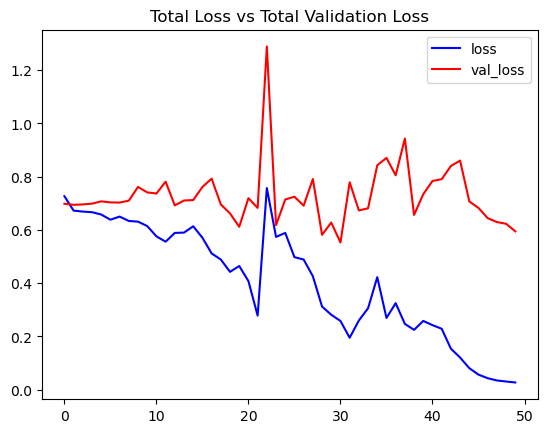

In [14]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

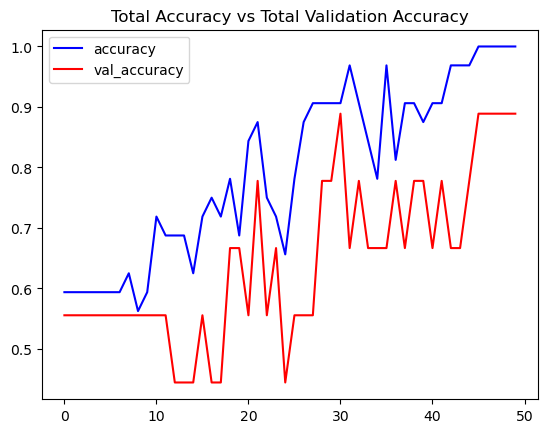

In [15]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# ============================================================

## Dataset with Augmented Video Files
# ----------------------------------------------------------------------

###  Create Training Set

In [16]:
# Specify the height and width to resize frame.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the number of frames used as one sequence.
SEQUENCE_LENGTH = 60

# Specify the directory containing the dataset. 
DATASET_DIR = "LimporNottrain"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["Limp", "No_Limp"]

### Extract the Data

In [17]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Limp
Extracting Data of Class: No_Limp


### Convert Labels to One-Hot Encoded Vectors

In [18]:
# Converting labels to one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)

### Shuffle

In [19]:
# Shuffle the training set.
features, one_hot_encoded_labels = shuffle(features, one_hot_encoded_labels)

In [20]:
# Create train features and labels.
features_train = features
labels_train = one_hot_encoded_labels

## Create Validation Set

In [21]:
# Specify the height and width to resize frames.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the number of frames to use as one sequence.
SEQUENCE_LENGTH = 60

# Specify the directory. 
DATASET_DIR = "LimporNotval"

# Specify the list containing the names of the classes.
CLASSES_LIST = ["Limp", "No_Limp"]

In [22]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Limp
Extracting Data of Class: No_Limp


In [23]:
# Convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)

In [24]:
# Create validation features and labels.
features_val = features
labels_val = one_hot_encoded_labels

## Create Test Set

In [25]:
# Specify the height and width to resize frames.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the number of frames to use as one sequence.
SEQUENCE_LENGTH = 60

# Specify the directory. 
DATASET_DIR = "LimporNottest"

# Specify the list containing the names of the classes. 
CLASSES_LIST = ["Limp", "No_Limp"]

In [26]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Limp
Extracting Data of Class: No_Limp


In [27]:
# Convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)

In [28]:
# Create test features and labels.
features_test = features
labels_test = one_hot_encoded_labels

### Create the Second LRCN Model

In [29]:
# Construct the LRCN model.
LRCN_model2 = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 60, 80, 80, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 60, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 60, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 60, 20, 20, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 60, 5, 5, 32)    

### Compile & Train the Model

In [30]:
# Create early stopping callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model2.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model2_training_history = LRCN_model2.fit(x = features_train, y = labels_train, epochs = 50,
                                             shuffle = True, validation_data= (features_val, labels_val), 
                                             batch_size = 4, callbacks = [early_stopping_callback])

Epoch 1/50
86/86 [==============================] - 29s 325ms/step - loss: 0.6946 - accuracy: 0.5673 - val_loss: 0.6998 - val_accuracy: 0.4848
Epoch 2/50
86/86 [==============================] - 27s 319ms/step - loss: 0.6616 - accuracy: 0.6140 - val_loss: 0.7093 - val_accuracy: 0.5152
Epoch 3/50
86/86 [==============================] - 27s 311ms/step - loss: 0.6541 - accuracy: 0.5789 - val_loss: 0.7293 - val_accuracy: 0.4949
Epoch 4/50
86/86 [==============================] - 27s 318ms/step - loss: 0.6196 - accuracy: 0.6550 - val_loss: 0.6987 - val_accuracy: 0.4848
Epoch 5/50
86/86 [==============================] - 26s 300ms/step - loss: 0.6090 - accuracy: 0.6550 - val_loss: 0.6951 - val_accuracy: 0.4646
Epoch 6/50
86/86 [==============================] - 26s 299ms/step - loss: 0.5978 - accuracy: 0.7105 - val_loss: 0.6576 - val_accuracy: 0.6162
Epoch 7/50
86/86 [==============================] - 25s 294ms/step - loss: 0.5888 - accuracy: 0.6579 - val_loss: 0.6907 - val_accuracy: 0.5556

### Evaluate the Trained Model

In [31]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model2.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 561ms/step - loss: 0.7738 - accuracy: 0.5514


### Plot Model’s Loss & Accuracy Curves

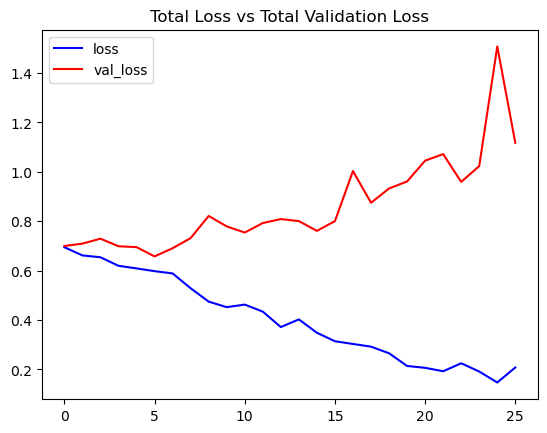

In [33]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model2_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

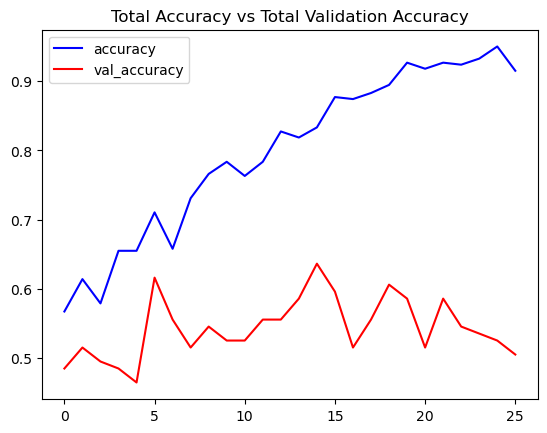

In [34]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model2_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# ---------------------------------------------------------------------------------